In [ ]:
# %%
import os
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
# exon-specific Δlogit
from helper import (
    load_and_align_for_delta_logit, pull_vectors_from_row,
    delta_logit_scores, curve_score_from_dlogit, hard_preds_from_dlogit,
    binary_metrics, find_contrastive_root, get_prediction_file,pull_pm1_vectors_from_row
)
import time

# --- Detect and set CONTRASTIVE_ROOT environment variable ---
root_path = str(find_contrastive_root())
os.environ["CONTRASTIVE_ROOT"] = root_path
print(f"✅ CONTRASTIVE_ROOT set to: {root_path}")

# --- Root Paths ---
ROOT_RESULTS = f"{root_path}/files/results"
DATA_BASE = f"{root_path}/data/ASCOT"

# --- Ground Truth Binary Files ---
GT_HIGH = f"{DATA_BASE}/variable_cassette_exons_with_binary_labels_HIGH_TissueBinPsi.csv"
GT_LOW  = f"{DATA_BASE}/variable_cassette_exons_with_binary_labels_LOW_TissueBinPsi.csv"

# --- Output directory ---
OUT_DIR = f"{ROOT_RESULTS}/../classification_eval"
os.makedirs(OUT_DIR, exist_ok=True)


✅ CONTRASTIVE_ROOT set to: /gpfs/commons/home/atalukder/Contrastive_Learning


In [2]:
def compute_classification_metrics_per_exon_logitdelta(
    gt_file: str,
    pred_file: str,
    model_name: str,
    expression_type: str  # "HIGH" or "LOW"
):
    merged, tissue_cols = load_and_align_for_delta_logit(
        gt_file=gt_file,
        pred_file=pred_file,
        require_cols=["logit_mean_psi"]
    )

    results = []
    for _, row in merged.iterrows():
        # 0/1 GT over tissues for this exon; PSI over tissues
        y_true, y_psi = pull_vectors_from_row(row, tissue_cols)
        if y_true.size == 0 or np.unique(y_true).size < 2:
            continue

        # Δlogit per tissue relative to this exon’s baseline
        muL = float(row["logit_mean_psi"])
        dlogit = delta_logit_scores(y_psi, muL)

        # Scores & hard predictions
        score_for_curve = curve_score_from_dlogit(dlogit, expression_type)
        y_pred = hard_preds_from_dlogit(dlogit, expression_type)

        m = binary_metrics(y_true, y_pred, score_for_curve)
        m.update({
            "model": model_name,
            "expression_type": expression_type,
            "exon_id": row["exon_id"],
        })
        results.append(m)

    df = pd.DataFrame(results)
    if df.empty:
        return df, f"⚠️ No valid exons found for {model_name} ({expression_type})\n"

    mean_metrics = df[["accuracy","precision","recall","f1","auroc","auprc"]].mean().round(4)
    summary_text = (
        f"\n📊 {model_name} ({expression_type} exons)\n"
        f"   n_exons   : {len(df)}\n" +
        "\n".join([f"   {k:<10}: {v:.4f}" for k,v in mean_metrics.items()]) + "\n"
    )
    return df, summary_text

In [ ]:
def evaluate_tissue_binary_pm1_logitdelta_per_tissue_exonloop(
    gt_file: str,            # wide GT with {-1,0,+1} and 'logit_mean_psi'
    pred_file: str,          # predictions (PSI; % OK)
    model_name: str = "",
    tissue_subset: list | None = None
) -> pd.DataFrame:
    """
    Binary tissue-specific evaluation:
      - Uses GT ∈ {-1,0,+1}; drops 0 and NaN; maps (-1 -> 0, +1 -> 1)
      - Score = Δlogit = logit(PSI_pred) − logit(mean_psi)
      - Hard label at 0: (Δlogit > 0) → 1
      - Aggregates per tissue across all exons in one exon-wise pass
    """
    merged, tissue_cols = load_and_align_for_delta_logit(
        gt_file=gt_file,
        pred_file=pred_file,
        require_cols=["logit_mean_psi"]
    )
    if tissue_subset is not None:
        tissue_cols = [t for t in tissue_cols if t in tissue_subset]

    # per-tissue accumulators
    acc = {t: {"y_true": [], "y_score": [], "y_pred": []} for t in tissue_cols}

    for _, row in merged.iterrows():
        # pull vectors for this exon (drop 0/NA, map -1/+1 -> 0/1)
        y_true_bin, y_psi, valid_mask = pull_pm1_vectors_from_row(row, tissue_cols)
        if y_true_bin.size == 0:
            continue

        # per-position Δlogit relative to this exon’s baseline
        muL = float(row["logit_mean_psi"])
        dlogit = delta_logit_scores(y_psi, muL)  # higher ⇒ more +1

        # hard preds at Δlogit=0
        y_pred = (dlogit > 0).astype(int)

        # scatter back to tissues using the mask’s positions
        pos = 0
        for j, t in enumerate(tissue_cols):
            if valid_mask[j]:
                acc[t]["y_true"].append(int(y_true_bin[pos]))
                acc[t]["y_score"].append(float(dlogit[pos]))
                acc[t]["y_pred"].append(int(y_pred[pos]))
                pos += 1

    # compute metrics per tissue
    rows = []
    for t in tissue_cols:
        yt = np.asarray(acc[t]["y_true"], dtype=int)
        ys = np.asarray(acc[t]["y_score"], dtype=float)
        yp = np.asarray(acc[t]["y_pred"], dtype=int)
        if yt.size == 0 or np.unique(yt).size < 2 or not np.isfinite(ys).all():
            rows.append({"tissue": t, "model": model_name, "n": int(yt.size),
                         "accuracy": np.nan, "precision": np.nan, "recall": np.nan, "f1": np.nan,
                         "auroc": np.nan, "auprc": np.nan})
            continue
        m = binary_metrics(yt, yp, ys)
        m.update({"tissue": t, "model": model_name, "n": int(yt.size)})
        rows.append(m)

    return pd.DataFrame(rows).sort_values(["tissue","model"]).reset_index(drop=True)


In [ ]:
# def compute_classification_metrics_per_exon_logitdelta(
#     gt_file: str,                # your HIGH/LOW CSV (keeps logit_mean_psi)
#     pred_file: str,              # predictions TSV
#     model_name: str,
#     expression_type: str         # "HIGH" or "LOW"
# ):
#     # Load
#     gt = _standardize_columns(pd.read_csv(gt_file))
#     pred = _standardize_columns(pd.read_csv(pred_file, sep="\t"))
#     pred = _detect_and_scale_predictions(pred)  # ensure PSI in [0,1]

#     # sanity: need logit_mean_psi
#     if "logit_mean_psi" not in gt.columns:
#         raise ValueError("Expected 'logit_mean_psi' in GT file.")

#     # tissues = intersection
#     tissue_cols = [c for c in pred.columns if c in gt.columns and c != "exon_id"]
#     if not tissue_cols:
#         raise ValueError("No overlapping tissue columns between GT and predictions.")

#     # Keep needed columns
#     gt_use   = gt[["exon_id", "logit_mean_psi"] + tissue_cols].drop_duplicates(subset=["exon_id"]).copy()
#     pred_use = pred[["exon_id"] + tissue_cols].drop_duplicates(subset=["exon_id"]).copy()

#     merged = pd.merge(gt_use, pred_use, on="exon_id", how="inner", suffixes=("_gt", "_pred"))

#     results = []
#     for _, row in merged.iterrows():
#         # GT binary labels across tissues (Int8 with NA)
#         y_true = pd.to_numeric(row[[f"{t}_gt" for t in tissue_cols]], errors="coerce").to_numpy(dtype="float64")
#         # Predicted PSI across tissues
#         y_psi  = pd.to_numeric(row[[f"{t}_pred" for t in tissue_cols]], errors="coerce").to_numpy(dtype="float64")
#         muL    = float(row["logit_mean_psi"])

#         # mask missing
#         mask = np.isfinite(y_true) & np.isfinite(y_psi)
#         if not np.any(mask):
#             continue
#         y_true = y_true[mask].astype(int)           # 0/1 GT already in HIGH/LOW CSVs
#         y_psi  = y_psi[mask]

#         # need both classes present
#         if np.unique(y_true).size < 2:
#             continue

#         # Δlogit score
#         y_score = delta_logit_scores(y_psi, muL)

#         if expression_type.upper() == "HIGH":
#             score_for_curve = -y_score   # invert for ROC/PR
#         else:
#             score_for_curve =  y_score

#         # Hard labels for accuracy/F1 stay as you wrote:
#         if expression_type.upper() == "HIGH":
#             y_pred = (y_score < 0).astype(int)
#         else:
#             y_pred = (y_score > 0).astype(int)

#         # metrics
#         exon_metrics = {
#             "model": model_name,
#             "expression_type": expression_type,
#             "exon_id": row["exon_id"],
#             "accuracy": accuracy_score(y_true, y_pred),
#             "precision": precision_score(y_true, y_pred, zero_division=0),
#             "recall": recall_score(y_true, y_pred, zero_division=0),
#             "f1": f1_score(y_true, y_pred, zero_division=0),
#         }
#         # AUROC/AUPRC on continuous Δlogit
#         # Then compute curves on score_for_curve
#         pos = y_true.sum(); neg = len(y_true) - pos
#         if pos > 0 and neg > 0 and np.isfinite(score_for_curve).all():
#             exon_metrics["auroc"] = roc_auc_score(y_true, score_for_curve)
#             exon_metrics["auprc"] = average_precision_score(y_true, score_for_curve)
#         else:
#             exon_metrics["auroc"] = np.nan
#             exon_metrics["auprc"] = np.nan


#         results.append(exon_metrics)

#     df = pd.DataFrame(results)
#     if df.empty:
#         return df, f"⚠️ No valid exons found for {model_name} ({expression_type})\n"

#     mean_metrics = df[["accuracy","precision","recall","f1","auroc","auprc"]].mean().round(4)
#     summary_text = (
#         f"\n📊 {model_name} ({expression_type} exons)\n"
#         f"   n_exons   : {len(df)}\n" +
#         "\n".join([f"   {k:<10}: {v:.4f}" for k,v in mean_metrics.items()]) + "\n"
#     )
#     return df, summary_text


In [3]:
def evaluate_exonSpecific_classification(result_file_name, model_user_name_norun):
    pred_file = get_prediction_file(ROOT_RESULTS, result_file_name)
    print(f"📂 Found predictions for {model_user_name_norun} → {pred_file}")

    df_high, txt_high = compute_classification_metrics_per_exon_logitdelta(
        GT_HIGH, pred_file, model_user_name_norun, "HIGH"
    )
    df_low,  txt_low  = compute_classification_metrics_per_exon_logitdelta(
        GT_LOW,  pred_file, model_user_name_norun, "LOW"
    )

    combined = pd.concat([df_high, df_low], ignore_index=True)
    out_csv = f"{OUT_DIR}/{model_user_name_norun}_classification_metrics_logitdelta.csv"
    combined.to_csv(out_csv, index=False)
    print(f"✅ Saved classification metrics → {out_csv}")
    return combined, txt_high + txt_low


In [ ]:
# --- Paths you likely already have ---
GT_CLASS3_WIDE = f"{DATA_BASE}/variable_cassette_exons_with_binary_labels_ExonBinPsi.csv"  # {-1,0,+1} wide

def evaluate_tissueSpecific_classification(result_file_name: str, model_user_name_norun: str):
    """
    Tissue-specific binary eval using GT {-1,+1} only (drops 0/NA).
    Score = Δlogit; metrics aggregated per tissue across exons.
    Requires GT_CLASS3_WIDE to contain columns: exon_id, logit_mean_psi, and tissue columns.
    """
    # 1) prediction file
    pred_file = get_prediction_file(ROOT_RESULTS, result_file_name)
    print(f"📂 Found predictions for {model_user_name_norun} → {pred_file}")

    # 2) Run tissue-specific eval (alignment, scaling, masking handled inside)
    per_tissue_df = evaluate_tissue_binary_pm1_logitdelta_per_tissue_exonloop(
        gt_file=GT_CLASS3_WIDE,
        pred_file=pred_file,
        model_name=model_user_name_norun,
        tissue_subset=None  # or pass a list to restrict/ordering
    )

    # 3) Save + summary text
    out_csv = f"{OUT_DIR}/{model_user_name_norun}_tissue_metrics_logitdelta.csv"
    per_tissue_df.to_csv(out_csv, index=False)
    print(f"✅ Saved tissue metrics → {out_csv}")

    n_tissues = per_tissue_df["tissue"].nunique()
    macro = per_tissue_df[["accuracy","precision","recall","f1","auroc","auprc"]].mean().round(4)
    summary = (
        f"\n🧪 {model_user_name_norun} (tissue-specific)\n"
        f"   n_tissues : {n_tissues}\n" +
        "\n".join([f"   {k:<10}: {v:.4f}" for k,v in macro.items()]) + "\n"
    )
    return per_tissue_df, summary


In [4]:
def plot_classification_summary(results_df, metric="auprc", out_name=None):
    plt.figure(figsize=(10, 5))
    sns.boxplot(
        data=results_df,
        x="expression_type",
        y=metric,
        hue="model",
        showfliers=False
    )
    plt.ylabel(metric.upper())
    plt.title(f"Per-exon {metric.upper()} distribution across models (HIGH/LOW exons)")
    plt.legend(loc="upper right", fontsize=8)
    plt.tight_layout()
    if out_name:
        out_path = f"{OUT_DIR}/{out_name}.png"
        plt.savefig(out_path, dpi=300, bbox_inches="tight")
        print(f"📊 Saved figure → {out_path}")
    plt.show()


In [ ]:
time_stamp = time.strftime("%Y_%m_%d__%H_%M_%S", time.localtime())
SUMMARY_TXT = f"{OUT_DIR}/ExonSpecific_classification_summary_{time_stamp}.txt"
summary_lines = ["===== MODEL CLASSIFICATION SUMMARY ====="]

# --- Model 1 ---
result_file_name1 =  "exprmnt_2025_10_28__20_28_29" # EMPRAIPsi_200bpIntrons_mtspliceHyperparams_2025_10_28__20_28_29
model1_user_name_norun = '200bpIntrons_mtspliceHyperparams'
df_model1, txt_model1 = evaluate_exonSpecific_classification(result_file_name1, model1_user_name_norun)
summary_lines += [txt_model1]

# --- Model 2 ---
result_file_name2 =  "exprmnt_2025_10_28__20_12_58" # EMPRAIPsi_300bpIntrons_mtspliceHyperparams_2025_10_28__20_12_58
model2_user_name_norun = '300bpIntrons_mtspliceHyperparams'
df_model2, txt_model2 = evaluate_exonSpecific_classification(result_file_name2, model2_user_name_norun)
summary_lines += [txt_model2]

# --- SOTA ---
sota_result_dir = "mtsplice_originalTFweight_results/intron_300bp_results"
sota_model_name_norun = "MTSplice_original_SOTA"
sota_pred_file = f"{ROOT_RESULTS}/{sota_result_dir}/test_all_tissues_predicted_psi.tsv"
print(f"📂 Using SOTA file → {sota_pred_file}")

df_sota_high, txt_sota_high = compute_classification_metrics_per_exon_logitdelta(GT_HIGH, sota_pred_file, sota_model_name_norun, "HIGH")
df_sota_low, txt_sota_low  = compute_classification_metrics_per_exon_logitdelta(GT_LOW,  sota_pred_file, sota_model_name_norun, "LOW")
summary_lines += [txt_sota_high, txt_sota_low]

df_sota = pd.concat([df_sota_high, df_sota_low], ignore_index=True)
df_sota.to_csv(f"{OUT_DIR}/{sota_model_name_norun}_classification_metrics.csv", index=False)

with open(SUMMARY_TXT, "w") as f:
    f.write("\n".join(summary_lines))



📂 Found predictions for 200bpIntrons_mtspliceHyperparams → /gpfs/commons/home/atalukder/Contrastive_Learning/files/results/exprmnt_2025_10_28__20_28_29/ensemble_evaluation_from_valdiation/test_set_evaluation/tsplice_final_predictions_all_tissues.tsv
✅ Saved classification metrics → /gpfs/commons/home/atalukder/Contrastive_Learning/files/results/../classification_eval/200bpIntrons_mtspliceHyperparams_classification_metrics_logitdelta.csv
📂 Found predictions for 300bpIntrons_mtspliceHyperparams → /gpfs/commons/home/atalukder/Contrastive_Learning/files/results/exprmnt_2025_10_28__20_12_58/ensemble_evaluation_from_valdiation/test_set_evaluation/tsplice_final_predictions_all_tissues.tsv
✅ Saved classification metrics → /gpfs/commons/home/atalukder/Contrastive_Learning/files/results/../classification_eval/300bpIntrons_mtspliceHyperparams_classification_metrics_logitdelta.csv
📂 Using SOTA file → /gpfs/commons/home/atalukder/Contrastive_Learning/files/results/mtsplice_originalTFweight_results/

✅ Combined summary saved → /gpfs/commons/home/atalukder/Contrastive_Learning/files/results/../classification_eval/combined_classification_summary.csv
📊 Saved figure → /gpfs/commons/home/atalukder/Contrastive_Learning/files/results/../classification_eval/AUPRC_SOTA_vs_models.png


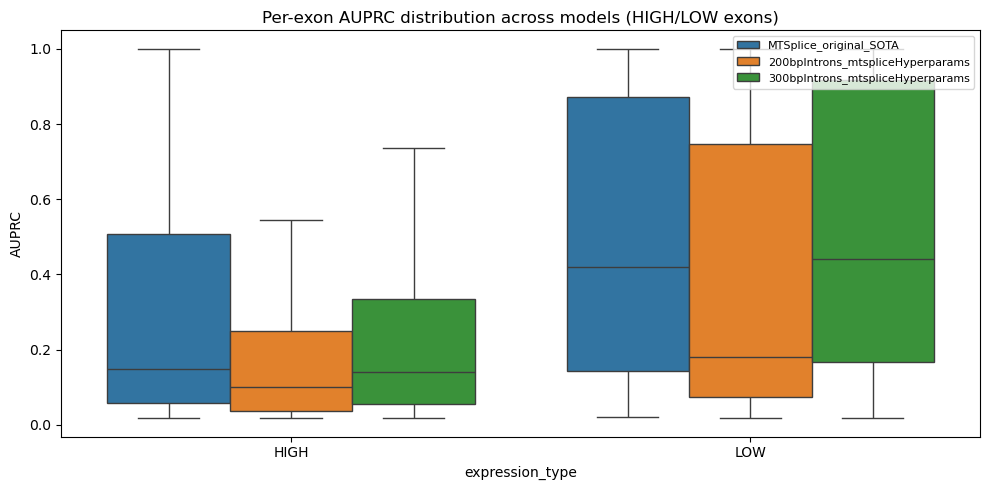

📊 Saved figure → /gpfs/commons/home/atalukder/Contrastive_Learning/files/results/../classification_eval/AUROC_SOTA_vs_models.png


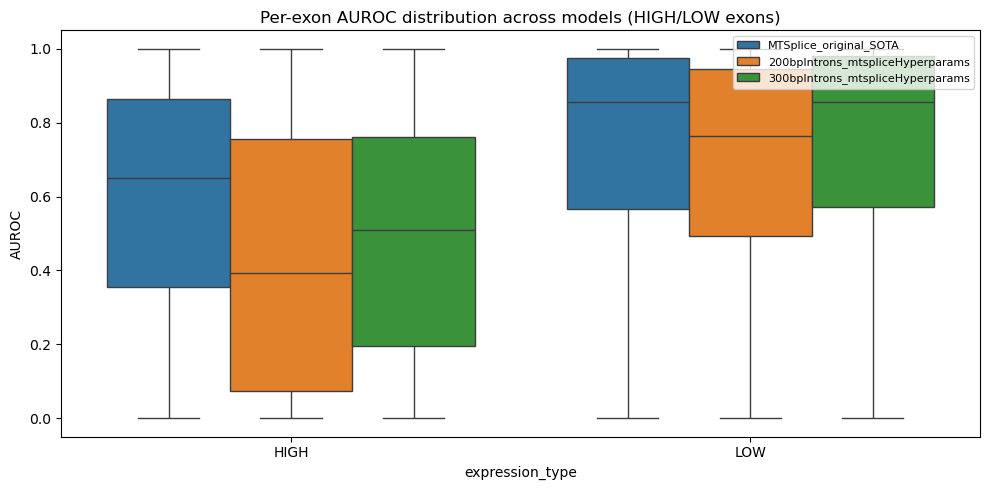

In [6]:
combined_all = pd.concat([df_sota, df_model1, df_model2], ignore_index=True)
combined_all.to_csv(f"{OUT_DIR}/combined_classification_summary.csv", index=False)
print(f"✅ Combined summary saved → {OUT_DIR}/combined_classification_summary.csv")

plot_classification_summary(combined_all, metric="auprc", out_name="AUPRC_SOTA_vs_models")
plot_classification_summary(combined_all, metric="auroc", out_name="AUROC_SOTA_vs_models")
